In [1]:
import numpy as np
from itertools import groupby
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#### Вхідні дані

In [2]:
alternatives = [[ 9,  3,  3,  7,  7,  3,  2,  9,  7,  6,  9,  10],
                [ 1,  5,  10, 4,  5,  6,  5,  10, 10, 4,  6,  7],
                [ 9,  4,  3,  6,  4,  4,  8,  3,  6,  6,  8,  9],
                [ 4,  9,  9,  3,  6,  9,  7,  7,  4,  1,  7,  4],
                [ 10, 8,  10, 10, 1,  8,  5,  8,  10, 2,  5,  2],
                [ 2,  6,  10, 10, 3,  8,  2,  10, 8,  8,  1,  7],
                [ 6,  5,  10, 5,  2,  8,  5,  3,  3,  9,  7,  1],
                [ 4,  9,  5,  4,  6,  10, 5,  5,  6,  4,  1,  8],
                [ 1,  10, 7,  2,  4,  1,  2,  5,  3,  3,  4,  4],
                [ 10, 10, 9,  4,  8,  3,  2,  5,  1,  6,  9,  9],
                [ 5,  2,  4,  4,  6,  4,  7,  8,  7,  8,  10, 5],
                [ 2,  5,  8,  4,  4,  3,  4,  4,  1,  7,  9,  2],
                [ 3,  5,  7,  3,  1,  5,  1,  8,  9,  3,  8,  2],
                [ 10, 2,  10, 4,  6,  2,  2,  10, 10, 4,  5,  7],
                [ 10, 6,  9,  8,  5,  6,  5,  3,  8,  6,  9,  9]]

weights = [6, 3, 7, 6, 7, 2, 6, 2, 5, 2, 3, 7]

c = 0.657 
d = 0.356


#### Завдання 1: ELECTRE I

In [3]:
# підрахунок max(Wj|aj-bj|)
def count_diff_ai_bi(alternatives_matrix, weights_array):
    alt = np.array(alternatives_matrix)
    weights = np.array(weights_array)
    diffs_ai_bi = []
    for i in range (0, len(alt[0,:])):
        diffs_ai_bi.append(weights[i]*(np.amax(alt[:, i])-np.amin(alt[:,i])))
    return diffs_ai_bi

# сума Pij(+) та Pij(=)
def sum_ij(a1, a2, weights_array):
    result_sum = 0
    for i in range(0, len(a1)):
        if a1[i] >= a2[i]:
            result_sum += weights_array[i]
    return result_sum

# формування матриці с
def c_matrix(alternatives_matrix, weights_array):
    result_matrix = [[0]*15 for i in range(15)]
    weights_sum = np.sum(weights_array)
    for i in range(0, 15):
        for j in range(0, 15):
            if i != j:
                result_matrix[i][j] = sum_ij(alternatives_matrix[i], alternatives_matrix[j], weights_array)/weights_sum
    return result_matrix

# підрахунок dij
def d_ij(a1, a2, weights_array, diffs_ai_bi):
    diffs = []
    selected_diffs_ai_bi = []
    for i in range(0, len(a1)):
        if a1[i] < a2[i]:
            # обчислюємо Wj|xj-yj|
            diffs.append(weights_array[i]*(a2[i]-a1[i]))
            selected_diffs_ai_bi.append(diffs_ai_bi[i]) 
    # max{Wj|xj-yj|}/max{Wj|aj-bj|}
    try:
        return np.amax(diffs)/np.amax(selected_diffs_ai_bi)
    except:
        return 0

# формування матриці d
def d_matrix(alternatives_matrix, weights_array):
    result_matrix = [[1]*15 for i in range(15)]
    diffs_ai_bi = count_diff_ai_bi(alternatives_matrix, weights_array)
    for i in range(0, 15):
        for j in range(0, 15):
            if i != j:
                result_matrix[i][j] = d_ij(alternatives_matrix[i], alternatives_matrix[j], weights_array, diffs_ai_bi)
    return result_matrix

def write_to_file(filename, matrix, formated):
    f = open(filename, "w") 
    if formated:
        for i in range(0,len(matrix)):
            for j in range(0,len(matrix)):
                f.write("{:.3f} ".format(matrix[i][j]))
            f.write('\n')
    else:
        for i in range(0,len(matrix)):
            for j in range(0,len(matrix)):
                f.write(" {} ".format(matrix[i][j]))
            f.write('\n')
    f.close()            
    
# ELECTRE I
def electre_I(alternatives_matrix, weights_array, c, d):
    # формуємо матрисі c та d
    C_matrix = np.array(c_matrix(alternatives_matrix, weights_array))
    D_matrix = np.array(d_matrix(alternatives_matrix, weights_array))
    relation_matrix = [[0]*15 for i in range(15)]
    write_to_file("c_matrix.txt", C_matrix, True)
    write_to_file("d_matrix.txt", D_matrix, True)
    R = []
    X = []    
    for i in range(0, len(C_matrix)):
        for j in range(0, len(C_matrix)):
            # якщо виконується необхідна (Сху>=C) та достатня (Dxy<=D) умови
            # альтернатива i переважає над j
            if i != j and C_matrix[i][j] >= c and D_matrix[i][j] <= d:
                relation_matrix[i][j] = 1
                R.append([i, j])
    write_to_file("relation_matrix.txt", relation_matrix, False)
    # додавання до ядра елементів, які є непорівнюваними (не увійшли до списку, внутрішня стійкість)
    for i in range(0, 15):
        flag = True
        for j in range(0, len(R)):
            if i in R[j]:
                flag = False
                break
        if flag:
            X.append(i)
    # перевірка на зовнішню стійкість (чи не переважає який-небудь елемент над елементом, який переважає над іншим)
    # та додавання зовнішньо стійких до ядра
    for i in range(0, len(R)):
        pair = R[i]
        x_candidate = pair[0]
        flag = True
        for j in range(0, len(R)):
            pair_compare = R[j]
            if pair_compare[1] == x_candidate:
                flag = False
                break
        if flag:
            X.append(x_candidate)
    X.sort()
    X_result = [el for el, _ in groupby(X)]
    for i in range(0, len(X_result)):
        X_result[i] = X_result[i] + 1
    return X_result

print("X*: {}".format(electre_I(alternatives, weights, c, d)))

                

X*: [3, 4, 5, 10, 11, 14, 15]


#### 2.1. Визначення впливу зміни порогового значення d на склад та розмір ядра

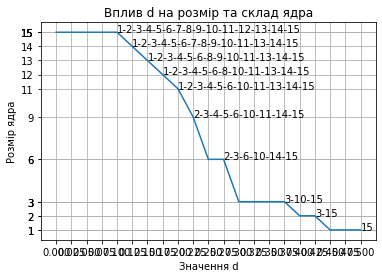

In [4]:
c_fixed = 0.5
# значення d з кроком 0.025
d_values = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 
            0.45, 0.475, 0.5]
# розмір ядра
kernels1 = []
# склад ядра
elements1 = []
for i in range(0, len(d_values)):
    result = electre_I(alternatives, weights, c_fixed, d_values[i])
    kernels1.append(len(result))
    elements1.append('-'.join(str(e) for e in result))

fig = plt.figure()
plt.plot(d_values, kernels1)
plt.xticks(d_values)
plt.yticks(kernels1)
plt.title('Вплив d на розмір та склад ядра')
plt.xlabel("Значення d")
plt.ylabel("Розмір ядра")
plt.grid(True)
for i in range (0, len(elements1)):
    try:
        if kernels1[i] != kernels1[i+1]:
            plt.text(d_values[i], kernels[i], elements1[i])
    except:
        plt.text(d_values[i], kernels1[i], elements1[i])
plt.show()

#### 2.2. Визначення впливу зміни порогового значення c на склад та розмір ядра


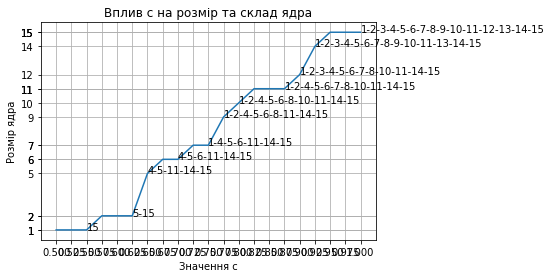

In [5]:
d_fixed = 0.49
# значення с з кроком 0.025
c_values = [0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 
            0.95, 0.975, 1]
# розмір ядра
kernels2 = []
# склад ядра
elements2 = []
for i in range(0, len(d_values)):
    result = electre_I(alternatives, weights, c_values[i], d_fixed)
    kernels2.append(len(result))
    elements2.append('-'.join(str(e) for e in result))

fig = plt.figure()
plt.plot(c_values, kernels2)
plt.xticks(c_values)
plt.yticks(kernels2)
plt.title('Вплив c на розмір та склад ядра')
plt.xlabel("Значення c")
plt.ylabel("Розмір ядра")
plt.grid(True)
for i in range (0, len(elements2)):
    try:
        if kernels2[i] != kernels2[i+1]:
            plt.text(c_values[i], kernels2[i], elements2[i])
    except:
        plt.text(c_values[i], kernels2[i], elements2[i])
plt.show()

#### 2.3. Визначення впливу одночасної зміни порогових значень DI та CI на склад та розмір ядра

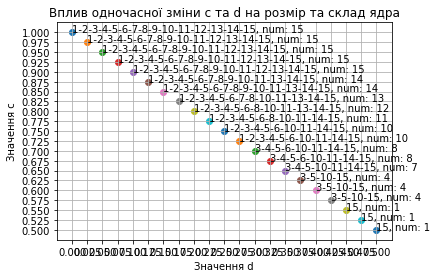

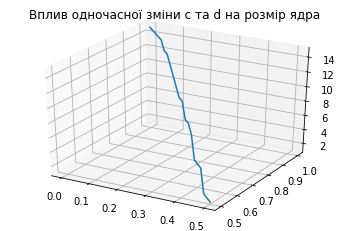

In [6]:
sorted_c_values = c_values
sorted_c_values.sort(reverse = True)
# розмір ядра
kernels3 = []
# склад ядра
elements3 = []
fig = plt.figure()
plt.title('Вплив одночасної зміни c та d на розмір та склад ядра')
plt.xlabel("Значення d")
plt.ylabel("Значення c")
for i in range(0, len(d_values)):
    result = electre_I(alternatives, weights, sorted_c_values[i], d_values[i])
    kernels3.append(len(result))
    elements3.append('-'.join(str(e) for e in result))
for i in range (0, len(elements3)):
    plt.scatter(d_values[i], sorted_c_values[i])
    # для кожної пари значень (d,c) на графіку вказано склад ядра та кількість його елементів
    plt.text(d_values[i], sorted_c_values[i], "{0}, num: {1}".format(elements3[i], kernels3[i]))
plt.grid(True)
plt.xticks(d_values)
plt.yticks(sorted_c_values)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('Вплив одночасної зміни c та d на розмір ядра')
ax.plot(d_values, sorted_c_values, kernels3)